# 10/25 18:30

# 10/26 오전작업

In [18]:
import cv2
import os
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
from keras.models import load_model, Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img 
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline
import pickle
from tqdm import tqdm
import json
from pprint import pprint
from sklearn.decomposition import PCA

# File name preprocessing

In [7]:
path = "/Users/suminbae/PycharmProjects/tf_cv2/aeye"
p_path = "/Users/suminbae/PycharmProjects/tf_cv2/aeye/persons"

# path = "/Users/suminbae/PycharmProjects/tf_cv2/AEYEPROJECT"
# p_path = "/Users/suminbae/PycharmProjects/tf_cv2/AEYEPROJECT/persons"

# change the working directory to the path where the images are located
os.chdir(p_path)

# this list holds all the image filename
persons = []



In [8]:
# creates a ScandirIterator aliased as files
with os.scandir(p_path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the flowers list
            persons.append(file.name)
            

In [9]:
len(persons)

330

In [10]:
persons

['frame_8_person_4.jpg',
 'frame_34_person_2.jpg',
 'frame_42_person_1.jpg',
 'frame_17_person_1.jpg',
 'frame_33_person_2.jpg',
 'frame_45_person_1.jpg',
 'frame_10_person_1.jpg',
 'frame_9_person_3.jpg',
 'frame_21_person_3.jpg',
 'frame_35_person_5.jpg',
 'frame_43_person_6.jpg',
 'frame_16_person_6.jpg',
 'frame_32_person_5.jpg',
 'frame_26_person_3.jpg',
 'frame_44_person_6.jpg',
 'frame_11_person_6.jpg',
 'frame_11_person_7.jpg',
 'frame_44_person_7.jpg',
 'frame_50_person_1.jpg',
 'frame_32_person_4.jpg',
 'frame_26_person_2.jpg',
 'frame_16_person_7.jpg',
 'frame_43_person_7.jpg',
 'frame_21_person_2.jpg',
 'frame_35_person_4.jpg',
 'frame_9_person_2.jpg',
 'frame_33_person_3.jpg',
 'frame_34_person_3.jpg',
 'frame_13_person_8.jpg',
 'frame_8_person_5.jpg',
 'frame_8_person_7.jpg',
 'frame_34_person_1.jpg',
 'frame_42_person_2.jpg',
 'frame_17_person_2.jpg',
 'frame_33_person_1.jpg',
 'frame_45_person_2.jpg',
 'frame_10_person_2.jpg',
 'frame_35_person_6.jpg',
 'frame_43_person

# Calling model process

In [11]:
# model = InceptionResNetV2()
# model = Model(inputs = model.inputs, outputs = model.layers[-2].output)


model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

# Extracting feature process

In [12]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# 10/26 30프레임으로 늘려서 131->211 사람이미지 데이터 확보

# 10/26 15:24 50프레임 늘려서 211->330 

In [13]:
data = {}
p = r"CHANGE TO A LOCATION TO SAVE FEATURE VECTORS"

# lop through each image in the dataset
for person in tqdm(persons):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(person,model)
        data[person] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

100%|██████████| 330/330 [05:02<00:00,  1.09it/s]


# extracting feature 4096

In [14]:
data['frame_5_person_4.jpg'].shape

(1, 4096)

# reshaping 

In [15]:
keys_values = data.items()
new_d = {key: value.reshape(4096) for key, value in keys_values}

In [16]:
images = list(new_d.values())

# 10/26 12:20 k값 연구 방법 => elbow method

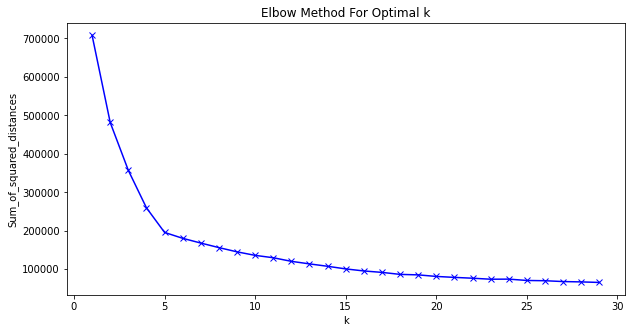

In [17]:
plt.figure(figsize=(10,5))
fns = list(new_d.keys())
sum_of_squared_distances = []
K = range(1, 30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(images)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [14]:
km.inertia_

8345.023523692713

0.44935644
0.47375017
0.42588648
0.43756464
0.4319727
0.35078397


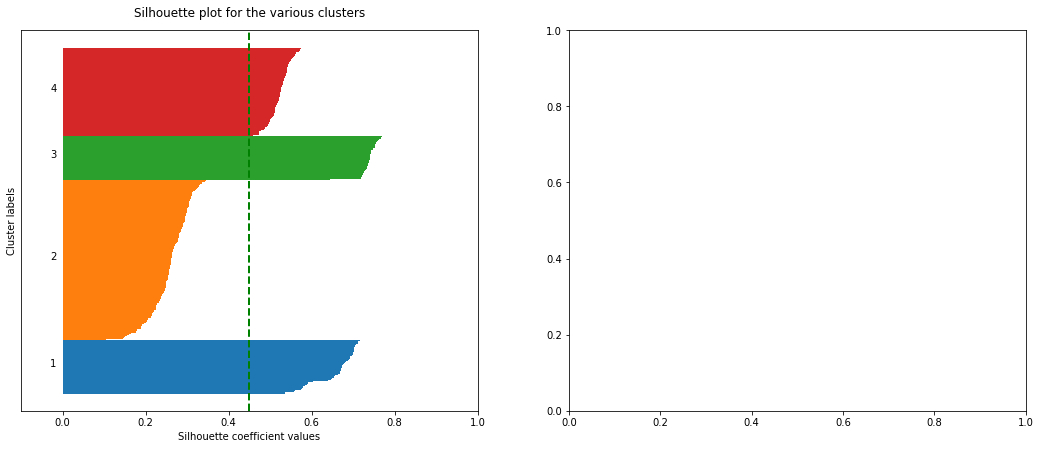

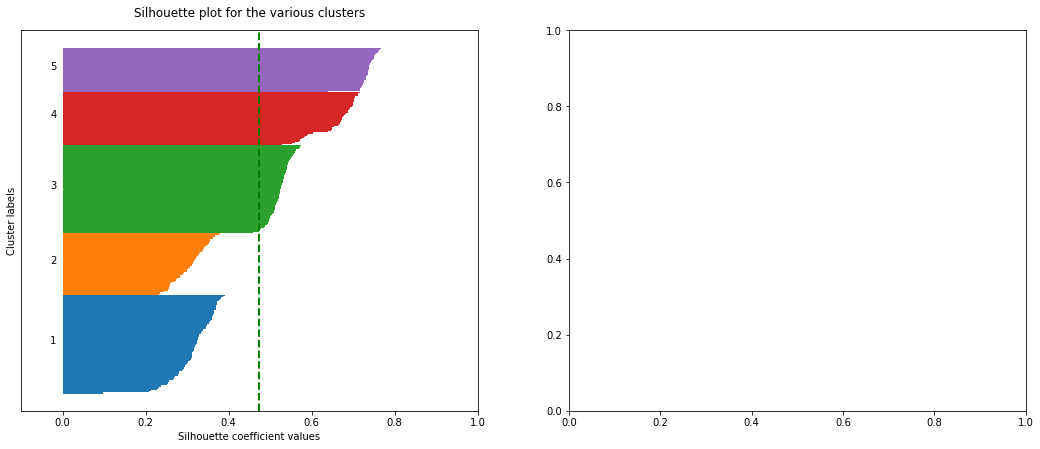

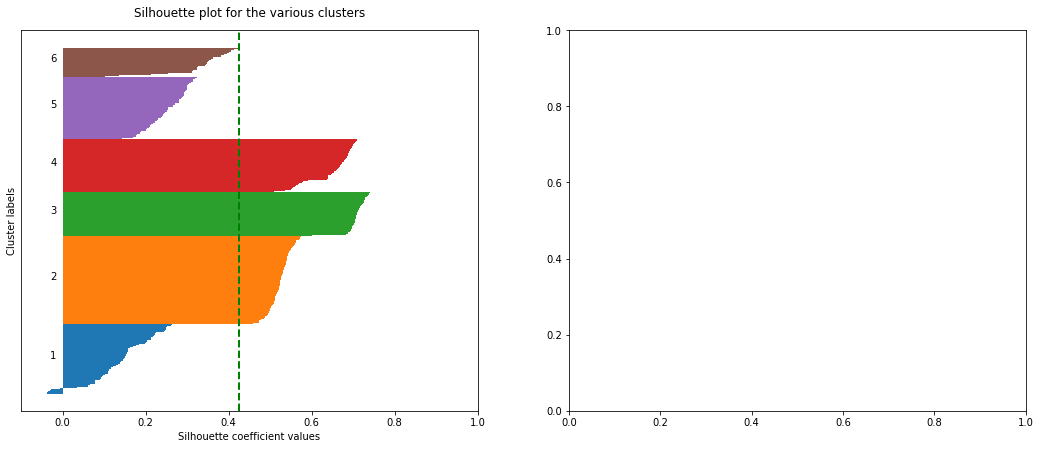

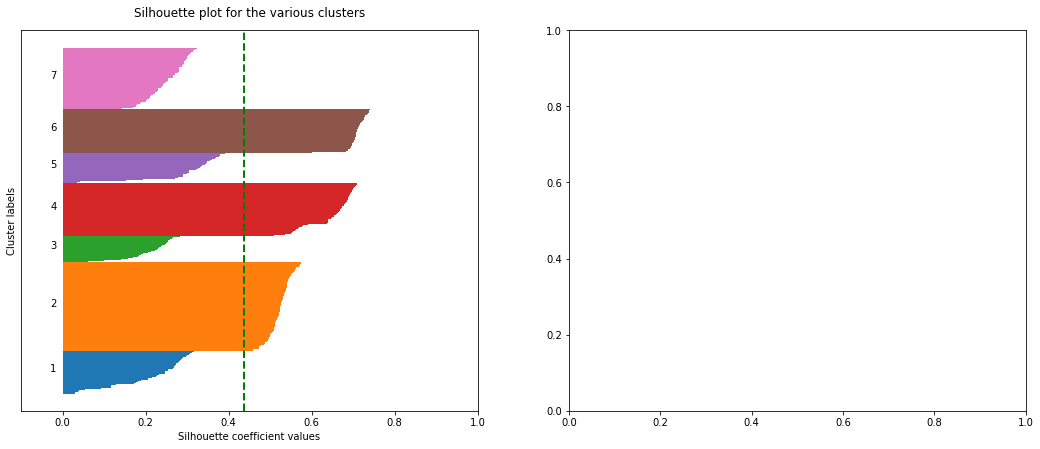

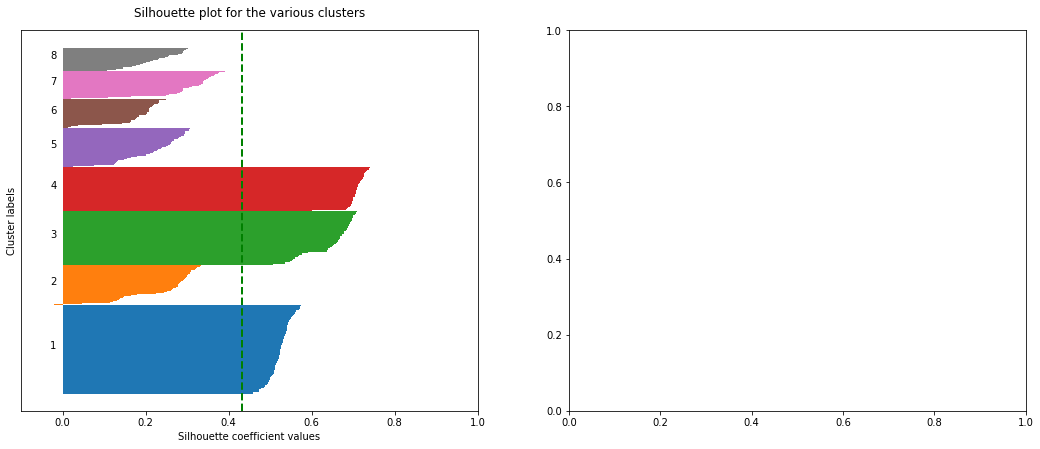

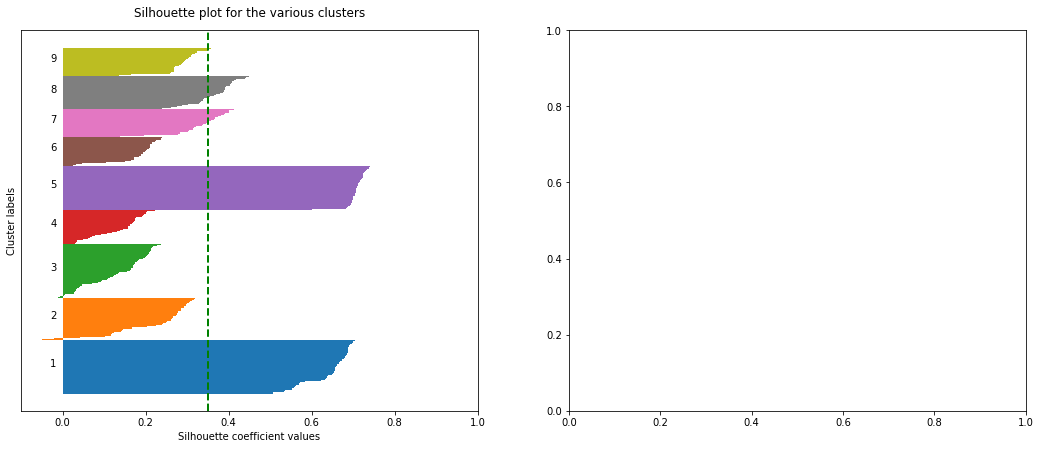

In [28]:
for i, k in enumerate([4, 5, 6,7,8,9]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(images)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(images, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    print(avg_score)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
#     # Scatter plot of data colored with labels
#     ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
#     ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
#     ax2.set_xlim([-2, 2])
#     ax2.set_xlim([-2, 2])
#     ax2.set_xlabel('Eruption time in mins')
#     ax2.set_ylabel('Waiting time to next eruption')
#     ax2.set_title('Visualization of clustered data', y=1.02)
#     ax2.set_aspect('equal')
#     plt.tight_layout()
#     plt.suptitle(f'Silhouette analysis using k = {k}',
#                  fontsize=16, fontweight='semibold', y=1.05);

# k=5인 지점에서 꺾이는 연구로 추정해서 k값을 적절히 추정

# Clustering

In [29]:
n_clusters=5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
kmeans.fit(images)
y_kmeans = kmeans.predict(images)



In [30]:
kmeans_labels_int = list(kmeans.labels_)
kmeans_labels_int = list(map(int, kmeans_labels_int))

In [31]:
groups = {}

for file, cluster in zip(persons,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# Changing key value to numpy int32 -> int

In [32]:
keys_values = groups.items()
groups = {int(key): value for key, value in keys_values}

# Groups ==Cluster result

In [33]:
groups.keys()

dict_keys([2, 0, 3, 4, 1])

# Cluster별 feature 벡터 모아서 시각화

In [34]:
def plot_group(group_num):
    plt.figure(figsize=(15,10))
    for i in range(10):
        plt.subplot(2,5,i+1)
        image_dir = p_path+"/"+groups[group_num][i]
        readed_img = mpimg.imread(image_dir)
        plt.title(groups[group_num][i])
        plt.imshow(readed_img)
    

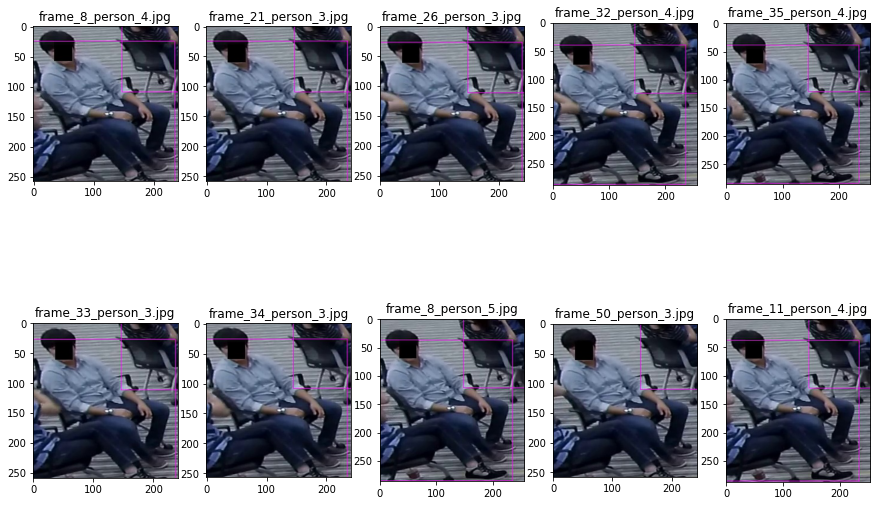

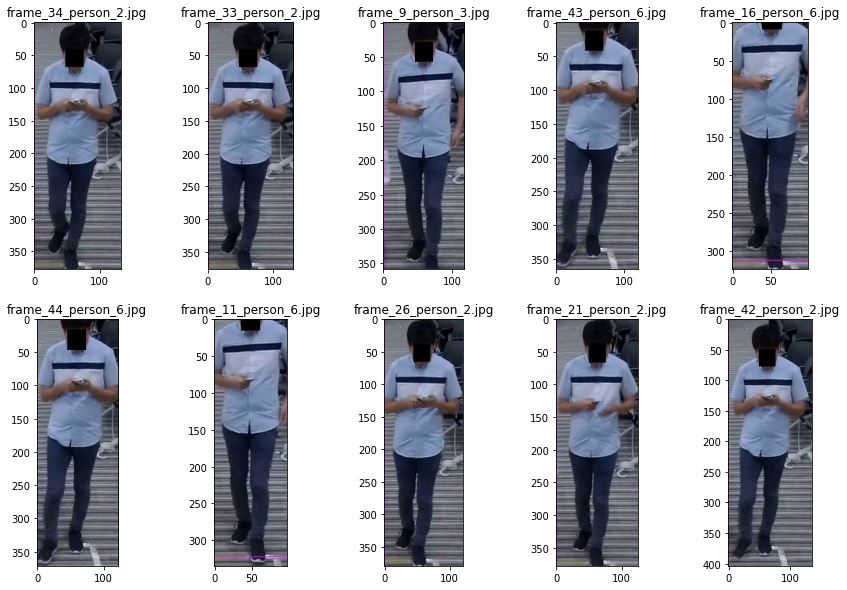

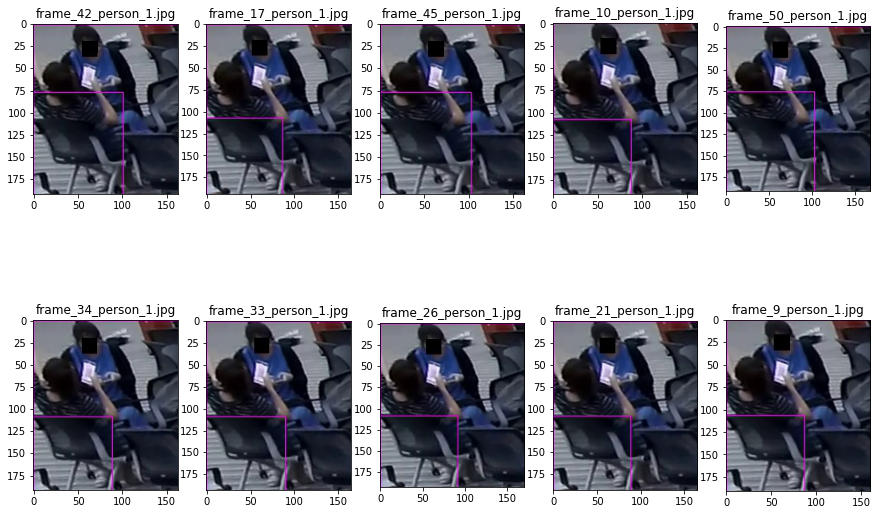

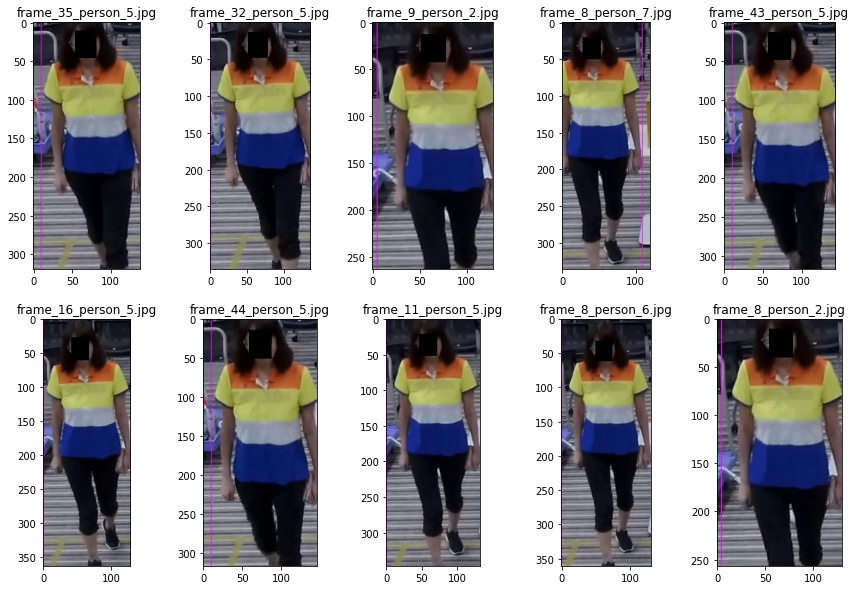

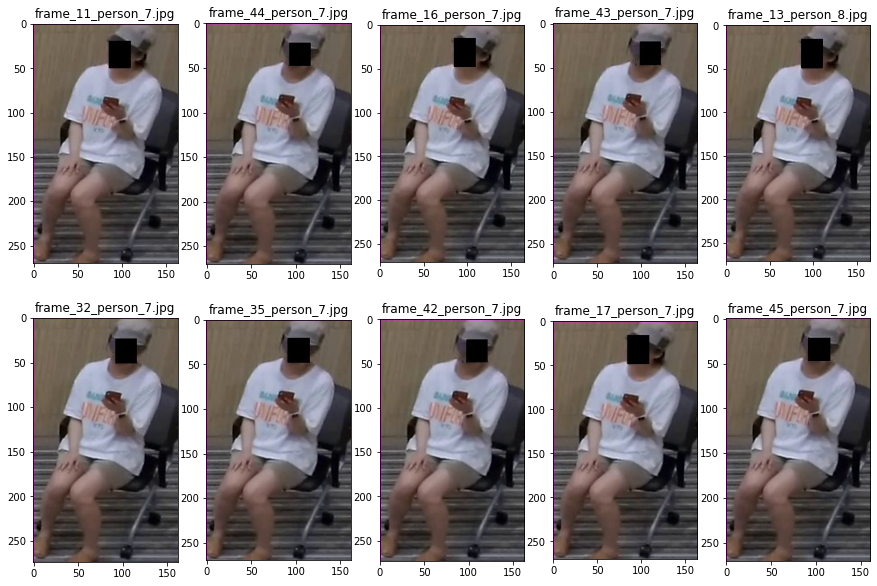

In [35]:
for clust in groups.keys():
    plot_group(clust)

# Visulalization Process

In [217]:
# g0_features = []
# g1_features = []
# g2_features = []
# g3_features = []
# g4_features = []


# for val in groups[0]:
#     g0_features.append(data[val])

# for val in groups[1]:
#     g1_features.append(data[val])
    
# for val in groups[2]:
#     g2_features.append(data[val])
    
    
# for val in groups[3]:
#     g3_features.append(data[val])    
    
    
# for val in groups[4]:
#     g4_features.append(data[val])  
    
# a = np.array(g0_features)
# a = a.reshape(-1,4096)

# b =np.array(g1_features)
# b = b.reshape(-1,4096)

# c = np.array(g2_features)
# c = c.reshape(-1,4096)

# d = np.array(g3_features)
# d = d.reshape(-1,4096)

# e = np.array(g4_features)
# e = e.reshape(-1,4096)

# pca0 = PCA(n_components=10)
# pca1 = PCA(n_components=10)
# pca2 = PCA(n_components=10)
# pca3 = PCA(n_components=10)
# pca4 = PCA(n_components=10)


# g0_reduced = pca0.fit_transform(a)
# g1_reduced = pca1.fit_transform(b)
# g2_reduced = pca2.fit_transform(c)
# g3_reduced = pca3.fit_transform(d)
# g4_reduced = pca4.fit_transform(e)


# plt.figure(figsize=(10,10))
# plt.scatter(x=g0_reduced[:,0],y=g0_reduced[:,1:2],label="Person_1")
# plt.scatter(x=g1_reduced[:,0],y=g1_reduced[:,1:2],c="red",label="Person_2")
# plt.scatter(x=g2_reduced[:,0],y=g2_reduced[:,1:2],c="green",label="Person_3")
# plt.scatter(x=g3_reduced[:,0],y=g3_reduced[:,1:2],c="purple",label="Person_4")
# plt.scatter(x=g4_reduced[:,0],y=g4_reduced[:,1:2],c="orange",label="Person_5")
# plt.legend()

# Saving as dictionary file to read from javascript


In [218]:
os.chdir(path)

with open('10271111.json','w') as f:
    json.dump(groups,f)




    

# 3-D Plottering image vector

In [219]:

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(g0_reduced[:,0:1], g0_reduced[:,1:2], g0_reduced[:,2:3], marker='o', s=15,label="cluster_1")
# ax.scatter(g1_reduced[:,0:1], g1_reduced[:,1:2], g1_reduced[:,2:3], marker='o', s=15,color="red",label="cluster_2")
# ax.scatter(g2_reduced[:,0:1], g2_reduced[:,1:2], g2_reduced[:,2:3], marker='o', s=15,color="green",label="cluster_3")
# ax.scatter(g3_reduced[:,0:1], g3_reduced[:,1:2], g3_reduced[:,2:3], marker='o', s=15,color="orange",label="cluster_4")
# ax.scatter(g4_reduced[:,0:1], g4_reduced[:,1:2], g4_reduced[:,2:3], marker='o', s=15,color="purple",label="cluster_5")
# plt.legend()



# 10/26 오후 Feature vector comparison

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm
from scipy import spatial

In [37]:
os.chdir(path)

In [38]:
# 코사인 유사도 함수 
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

    
def cos_sim_sci(A,B):
    return 1 - spatial.distance.cosine(A,B)
    

# Target image 예시

(1, 4096)


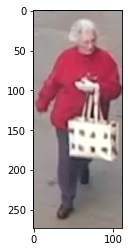

In [39]:
target_img = cv2.imread('test.jpg')
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
target_feature = extract_features("test.jpg",model)
print(target_feature.shape)
plt.imshow(target_img)

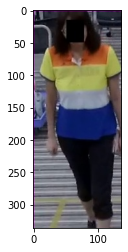

In [40]:
test1 = cv2.imread('test1.jpg')
test1 = cv2.cvtColor(test1, cv2.COLOR_BGR2RGB)
test1_feature = extract_features("test1.jpg",model)
plt.imshow(test1)

In [41]:
cos_sim_sci(target_feature,test1_feature)

0.3849810063838959

# n_cluster: 군집수 

# data: img별 feature vector 모음

In [42]:
data

{'frame_8_person_4.jpg': array([[ 0.57874304, -0.        ,  1.3907595 , ..., -0.        ,
         -0.        ,  3.6406918 ]], dtype=float32),
 'frame_34_person_2.jpg': array([[-0.       , -0.       ,  2.9854102, ..., -0.       , -0.       ,
         -0.       ]], dtype=float32),
 'frame_42_person_1.jpg': array([[-0.       , -0.       ,  0.6103105, ..., -0.       , -0.       ,
          0.3516773]], dtype=float32),
 'frame_17_person_1.jpg': array([[-0., -0., -0., ..., -0., -0., -0.]], dtype=float32),
 'frame_33_person_2.jpg': array([[ 0.09326482, -0.        ,  2.8588738 , ..., -0.        ,
         -0.        ,  0.04333651]], dtype=float32),
 'frame_45_person_1.jpg': array([[-0.        , -0.        ,  0.5696946 , ..., -0.        ,
         -0.        ,  0.30089837]], dtype=float32),
 'frame_10_person_1.jpg': array([[-0.        , -0.        , -0.        , ...,  0.00036311,
         -0.        , -0.        ]], dtype=float32),
 'frame_9_person_3.jpg': array([[ 1.0202445, -0.       ,  2.61

In [43]:
groups.keys()

dict_keys([2, 0, 3, 4, 1])

In [44]:
cluster_mean ={}

for i in groups.keys():
    feature_lst = []
    for val in groups[i]:
        feature_lst.append(data[val])
    
    feature_lst_mean = np.array(feature_lst)
    feature_lst_mean = feature_lst_mean.mean(axis=0)
    print(feature_lst_mean.shape)
    cluster_mean[i] = feature_lst_mean
    
    
        
        



(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)


In [45]:
cluster_mean

{2: array([[0.67897886, 0.        , 1.3415439 , ..., 0.        , 0.        ,
         3.6489077 ]], dtype=float32),
 0: array([[0.72637   , 0.        , 2.8932183 , ..., 0.05208097, 0.10551906,
         0.502617  ]], dtype=float32),
 3: array([[0.        , 0.        , 0.2000805 , ..., 0.15024324, 0.        ,
         0.11457564]], dtype=float32),
 4: array([[0.01232491, 0.        , 0.13015182, ..., 0.16384958, 0.3495765 ,
         0.0958425 ]], dtype=float32),
 1: array([[0.        , 0.        , 0.02385202, ..., 0.00618331, 0.45155916,
         1.4153986 ]], dtype=float32)}

In [46]:
cos_sim_sci(cluster_mean[0],test1_feature)

0.6479346752166748

In [47]:
cluster_compare_result={}

In [48]:
cluster_compare_result={}
for key,val in cluster_mean.items():
    sim = cos_sim_sci(val,test1_feature)
    print(f"Compare to this cluster{key} sim with target: ",sim)
    cluster_compare_result[key] = sim
    
    
    
    

Compare to this cluster2 sim with target:  0.38194549083709717
Compare to this cluster0 sim with target:  0.6479346752166748
Compare to this cluster3 sim with target:  0.4376901388168335
Compare to this cluster4 sim with target:  0.9073546528816223
Compare to this cluster1 sim with target:  0.5504427552223206


In [49]:
cluster_compare_result

{2: 0.38194549083709717,
 0: 0.6479346752166748,
 3: 0.4376901388168335,
 4: 0.9073546528816223,
 1: 0.5504427552223206}

In [50]:
max_result = max(cluster_compare_result,key=cluster_compare_result.get) 

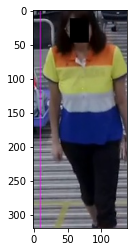

In [51]:
d = p_path+"/"+groups[max_result][0]
readed_img = mpimg.imread(d)
plt.imshow(readed_img)

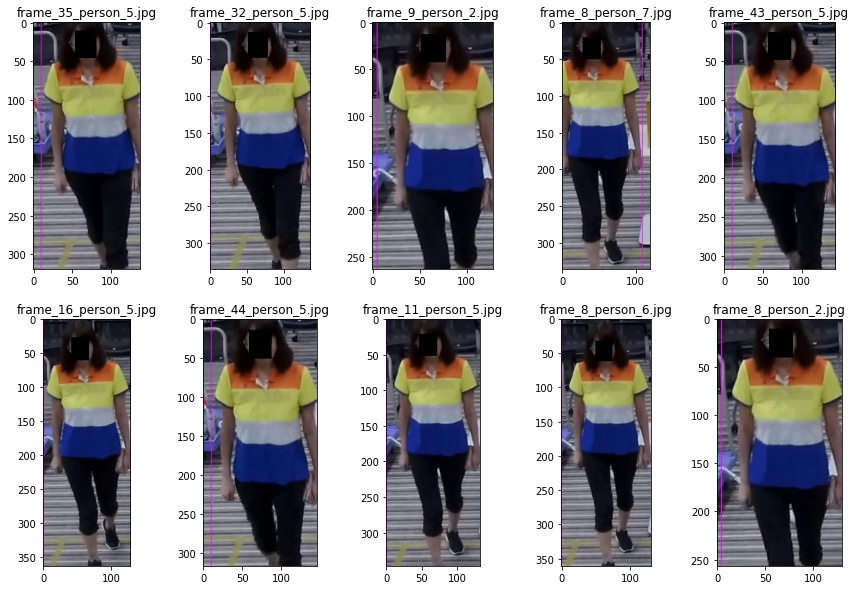

In [53]:
plot_group(4)

In [243]:
with open('10271111.json') as json_file:
    json_data = json.load(json_file)